# Connection probability model building of the whole SSCx circuit
## 2nd-order model coefficients summary & convergence analysis

In [1]:
# Global imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


### Merge files, if needed

In [13]:
# # [TO BE APPLIED FIRST, IF NEEDED] Merge coefficients from different files
# file_list = ['./modelling/tables/SSCx_model_params_order-2_midrange__1K-100K.h5',
#                    './modelling/tables/SSCx_model_params_order-2_midrange__200K.h5']
# merged_file = './modelling/tables/SSCx_model_params_order-2_midrange.h5'

# ## Read tables from several files
# sort_key = lambda x: int(x.replace('sub', ''))
# df_dict = {}
# for f in file_list:
#     for key in sorted(h5py.File(f).keys(), key=sort_key):
#         df_dict.update({key: pd.read_hdf(f, key)})

# ## Write tables into single file
# assert not os.path.exists(merged_file),' ERROR: Output file already exists!'
# for idx, key in enumerate(df_dict.keys()):
#     df_dict[key].to_hdf(merged_file, key=key, mode='r+' if idx else 'w') # Save to .h5 (appending)

### Load 2nd-order model coefficients (local & midrange)

In [2]:
# Load model coefficients
# [Computed by run_SSCx_model_building_order2_local.sh/py and
#  run_SSCx_model_building_order2_midrange.sh/py respectivels]

coefs_file_local = './modelling/tables/SSCx_model_params_order-2_local.h5'
coefs_file_midrange = './modelling/tables/SSCx_model_params_order-2_midrange.h5'

sort_key = lambda x: int(x.replace('sub', ''))
coef_dict_local = {}
for key in sorted(h5py.File(coefs_file_local).keys(), key=sort_key):
    coef_dict_local.update({sort_key(key): pd.read_hdf(coefs_file_local, key)})

coef_dict_midrange = {}
for key in sorted(h5py.File(coefs_file_midrange).keys(), key=sort_key):
    coef_dict_midrange.update({sort_key(key): pd.read_hdf(coefs_file_midrange, key)})


### Check convergence

In [3]:
def check_model_coef_convergence(coef_tables, title=None):
    """Visualizes parameter convergence for different numbers of samples"""
    sample_sizes = sorted(coef_tables.keys())
    coef_names = list(coef_tables[sample_sizes[0]].columns) # Assumed to be same for all tables!

    coef_means = []
    coef_stds = []
    coef_sems = []
    plt.figure(figsize=(6 * len(coef_names), 4))
    for cidx, cname in enumerate(coef_names):
        coef_mean = [coef_tables[smpl][cname].mean() for smpl in sample_sizes]
        coef_std = [coef_tables[smpl][cname].std() for smpl in sample_sizes]
        coef_sem = [coef_tables[smpl][cname].std() / np.sqrt(len(coef_tables[smpl][cname])) for smpl in sample_sizes]
        coef_means.append(coef_mean)
        coef_stds.append(coef_std)
        coef_sems.append(coef_sem)
        plt.subplot(len(coef_names), 2, cidx + 1)
        plt.plot(sample_sizes, coef_mean, '.-')
        plt.ylabel('Mean')
        plt.grid()
        plt.title(cname, fontweight='bold')
        plt.subplot(len(coef_names), 2, cidx + 1 + len(coef_names))
        plt.plot(sample_sizes, 100.0 * np.array(coef_sem) / np.array(coef_mean), '.-')
        plt.ylabel('Rel. SEM (%)')
        plt.gca().set_yscale('log')
        plt.grid()
        plt.xlabel('#Samples')
    if title is not None:
        plt.suptitle(title, fontweight='bold')
    plt.tight_layout()

    return coef_names, sample_sizes, coef_means, coef_stds, coef_sems

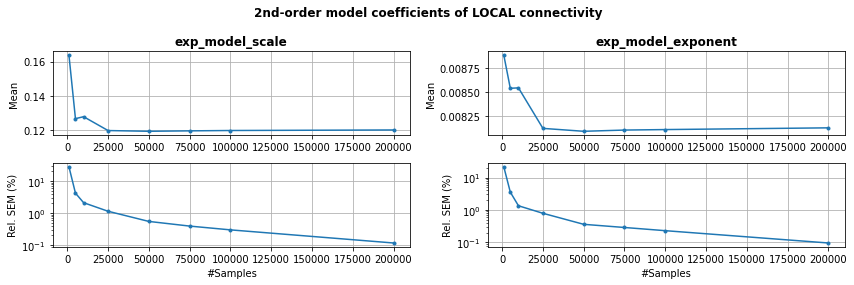

In [4]:
coef_names_local, sample_sizes_local, coef_means_local, coef_stds_local, coef_sems_local = check_model_coef_convergence(coef_dict_local, title='2nd-order model coefficients of LOCAL connectivity')

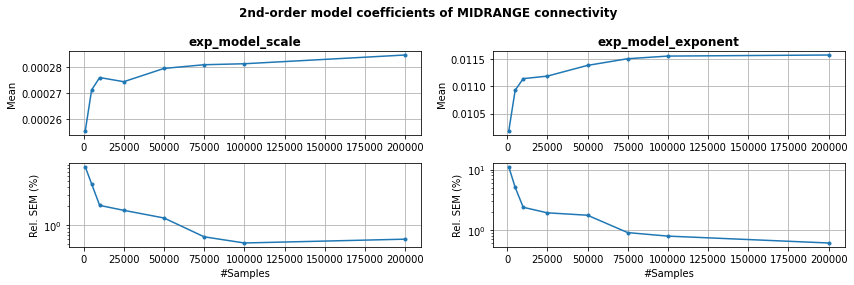

In [5]:
coef_names_midrange, sample_sizes_midrange, coef_means_midrange, coef_stds_midrange, coef_sems_midrange = check_model_coef_convergence(coef_dict_midrange, title='2nd-order model coefficients of MIDRANGE connectivity')

### Estimate max. error (rel. SEM) of resulting connection probabilities

In [6]:
def max_conn_prob_error(coef_table, dist):
    """Returns max. rel. SEM (in %) of connection probabilities."""
    p_dist_fct = lambda c0, c1, dist: c0 * np.exp(-c1 * dist)
    p_table = np.array([p_dist_fct(*coef_table.iloc[i].to_numpy(), dist) for i in range(coef_table.shape[0])])
    max_rsem_pct = np.max(100.0 * (np.std(p_table, 0) / np.sqrt(p_table.shape[0])) / np.mean(p_table, 0))
    return max_rsem_pct

In [7]:
# Local connectivity
dist_local = np.arange(0, 1000, 1) # (um)
coef_table_local = coef_dict_local[max(coef_dict_local.keys())] # Table with largest number of samples
max_p_error_local = max_conn_prob_error(coef_table_local, dist_local)

# Midrange connectivity
dist_midrange = np.arange(0, 400, 1) # (a.u.)
coef_table_midrange = coef_dict_midrange[max(coef_dict_midrange.keys())] # Table with largest number of samples
max_p_error_midrange = max_conn_prob_error(coef_table_midrange, dist_midrange)


### Print 2nd-order model coefficient estimates summary

In [8]:
print('LOCAL connectivity:')
for cidx, cname in enumerate(coef_names_local):
    print(f'  {cname}: {coef_means_local[cidx][-1]} (#samples={sample_sizes_local[-1]}, rSEM={100.0 * coef_sems_local[cidx][-1] / coef_means_local[cidx][-1]:.3f}%)')
print(f'  Max. p error: rSEM={max_p_error_local:.3f}%')

print('\nMIDRANGE connectivity:')
for cidx, cname in enumerate(coef_names_midrange):
    print(f'  {cname}: {coef_means_midrange[cidx][-1]} (#samples={sample_sizes_midrange[-1]}, rSEM={100.0 * coef_sems_midrange[cidx][-1] / coef_means_midrange[cidx][-1]:.3f}%)')
print(f'  Max. p error: rSEM={max_p_error_midrange:.3f}%')

LOCAL connectivity:
  exp_model_scale: 0.12000880697622222 (#samples=200000, rSEM=0.117%)
  exp_model_exponent: 0.008131292967038645 (#samples=200000, rSEM=0.096%)
  Max. p error: rSEM=0.640%

MIDRANGE connectivity:
  exp_model_scale: 0.0002847962181839291 (#samples=200000, rSEM=0.605%)
  exp_model_exponent: 0.011579350970857109 (#samples=200000, rSEM=0.612%)
  Max. p error: rSEM=1.974%
